1.  https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset/data - выбранный датасет для рассмотрения

2. Немного обработаем наш датасет, выбросив из него все строчные значения, а также добавим новый атрибут для расчета эффективности работы батареи устройства, чтобы понять, насколько определенное устройство эффекотивно распределяет заряд своей батареи. Формула: appEffectiveness = Battery Drain / App Usage Time


In [7]:
import pandas as pd 
import matplotlib.pyplot as plt 
from feature_engine.outliers import OutlierTrimmer
import plotly.express as px
import seaborn as sb 
dframe = pd.read_csv('user_behavior_dataset.csv') # прочитаем датасет

print(dframe.head())

   User ID    Device Model Operating System  App Usage Time (min/day)  \
0        1  Google Pixel 5          Android                       393   
1        2       OnePlus 9          Android                       268   
2        3    Xiaomi Mi 11          Android                       154   
3        4  Google Pixel 5          Android                       239   
4        5       iPhone 12              iOS                       187   

   Screen On Time (hours/day)  Battery Drain (mAh/day)  \
0                         6.4                     1872   
1                         4.7                     1331   
2                         4.0                      761   
3                         4.8                     1676   
4                         4.3                     1367   

   Number of Apps Installed  Data Usage (MB/day)  Age  Gender  \
0                        67                 1122   40    Male   
1                        42                  944   47  Female   
2                

Уберем несколько колонок, которые будут мешать нам обрабатывать датасет

In [8]:
input_data = dframe.drop(dframe.columns[[1, 2, 9]], axis=1)

print(input_data.head())

   User ID  App Usage Time (min/day)  Screen On Time (hours/day)  \
0        1                       393                         6.4   
1        2                       268                         4.7   
2        3                       154                         4.0   
3        4                       239                         4.8   
4        5                       187                         4.3   

   Battery Drain (mAh/day)  Number of Apps Installed  Data Usage (MB/day)  \
0                     1872                        67                 1122   
1                     1331                        42                  944   
2                      761                        32                  322   
3                     1676                        56                  871   
4                     1367                        58                  988   

   Age  User Behavior Class  
0   40                    4  
1   47                    3  
2   42                    2  
3   20  

Добавим новый атрибут в датафрейм

In [ ]:
input_data['DeviceEffectiveness'] = input_data['Screen On Time (hours/day)'] * 60 / input_data['App Usage Time (min/day)']
print(input_data.head())

   User ID  App Usage Time (min/day)  Screen On Time (hours/day)  \
0        1                       393                         6.4   
1        2                       268                         4.7   
2        3                       154                         4.0   
3        4                       239                         4.8   
4        5                       187                         4.3   

   Battery Drain (mAh/day)  Number of Apps Installed  Data Usage (MB/day)  \
0                     1872                        67                 1122   
1                     1331                        42                  944   
2                      761                        32                  322   
3                     1676                        56                  871   
4                     1367                        58                  988   

   Age  User Behavior Class  DeviceEffectiveness  
0   40                    4             0.977099  
1   47                    

Проверим датасет на пропуски

In [24]:
print(input_data.isnull().sum())

User ID                       0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
User Behavior Class           0
DeviceEffectiveness           0
dtype: int64


Рассмотрим диаграммы, для того, чтобы понять, есть ли выбросы или нет

In [25]:
for feature in input_data.columns:
    fig=px.box(input_data,y=feature,title="<b>"+feature,boxmode="group", template="plotly_dark",points="all")
    fig.update_layout(title_x=0.5,title_font_size=30,font_size=15,font_color="aqua")
    fig.show()

Теперь обработаем выбросы в нашей модели, будем использовать методы межквартильного размаха

In [26]:
columns = input_data.describe().columns.tolist()
capper = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=columns)
dataCopy = input_data.copy()
capper.fit(dataCopy)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both',
               variables=['User ID', 'App Usage Time (min/day)',
                          'Screen On Time (hours/day)',
                          'Battery Drain (mAh/day)', 'Number of Apps Installed',
                          'Data Usage (MB/day)', 'Age', 'User Behavior Class',
                          'DeviceEffectiveness'])

In [27]:
print(capper.right_tail_caps_)
print(capper.left_tail_caps_)

{'User ID': 1049.5, 'App Usage Time (min/day)': 915.75, 'Screen On Time (hours/day)': 14.75, 'Battery Drain (mAh/day)': 4490.375, 'Number of Apps Installed': 146.0, 'Data Usage (MB/day)': 2793.0, 'Age': 80.5, 'User Behavior Class': 7.0, 'DeviceEffectiveness': 2.064546624147265}
{'User ID': -348.5, 'App Usage Time (min/day)': -368.25, 'Screen On Time (hours/day)': -4.8500000000000005, 'Battery Drain (mAh/day)': -1538.625, 'Number of Apps Installed': -46.0, 'Data Usage (MB/day)': -1079.0, 'Age': -3.5, 'User Behavior Class': -1.0, 'DeviceEffectiveness': 0.41929687835663776}


Удалим выбросы с использованием границ, найденных через capper

In [28]:
dataCopy = capper.transform(dataCopy)

for feature in dataCopy.columns:
    fig=px.box(dataCopy,y=feature,title="<b>"+feature,boxmode="group", template="plotly_dark",points="all")
    fig.update_layout(title_x=0.5,title_font_size=30,font_size=15,font_color="aqua")
    fig.show()

Начнем кластеризацию, а количество кластеров определим ,используя метод локтя

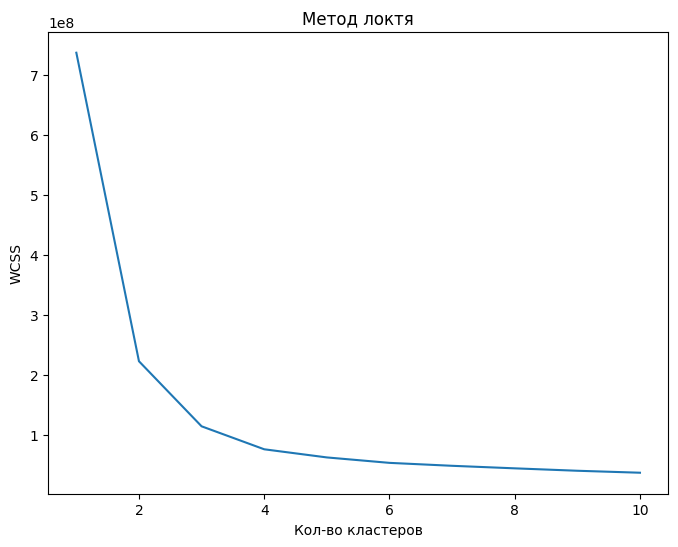

In [29]:
import matplotlib.pyplot as plt # импортируем библиотеку для графика.
from sklearn.cluster import KMeans # метод KMeans

X =dataCopy.values[:]
wcss = [] # wcss - within-cluster sum of squares, сумма квадратов внутрикластерных расстояний.
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=12, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.subplots(figsize=(8, 6))
plt.plot(range(1,11), wcss)
plt.title('Метод локтя')
plt.xlabel('Кол-во кластеров')
plt.ylabel('WCSS')
plt.show()

In [30]:
clustersQuantity = 2 # исходя из графика получили, что количество кластеров - 2.
k_means =KMeans(init='k-means++', n_clusters=clustersQuantity, n_init=12)
k_means.fit(X)
labels = k_means.labels_
dataCopy['cluster'] = labels
print(dataCopy.head())

   User ID  App Usage Time (min/day)  Screen On Time (hours/day)  \
0        1                       393                         6.4   
1        2                       268                         4.7   
2        3                       154                         4.0   
3        4                       239                         4.8   
4        5                       187                         4.3   

   Battery Drain (mAh/day)  Number of Apps Installed  Data Usage (MB/day)  \
0                     1872                        67                 1122   
1                     1331                        42                  944   
2                      761                        32                  322   
3                     1676                        56                  871   
4                     1367                        58                  988   

   Age  User Behavior Class  DeviceEffectiveness  cluster  
0   40                    4             0.977099        0  
1   47  

Построим графики для нескольких зависимостей

Text(0, 0.5, 'Data Usage')

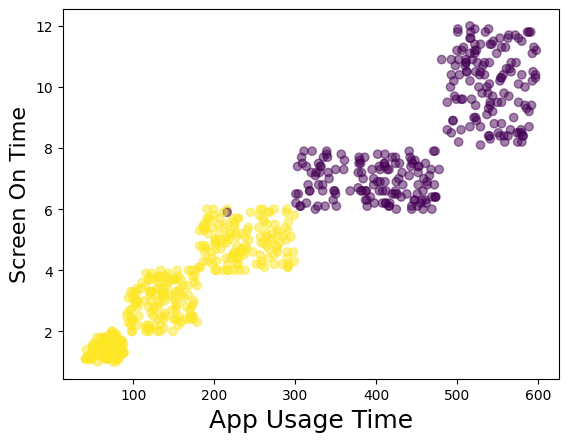

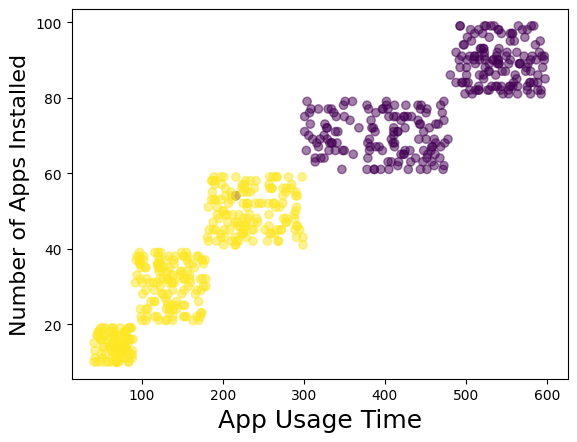

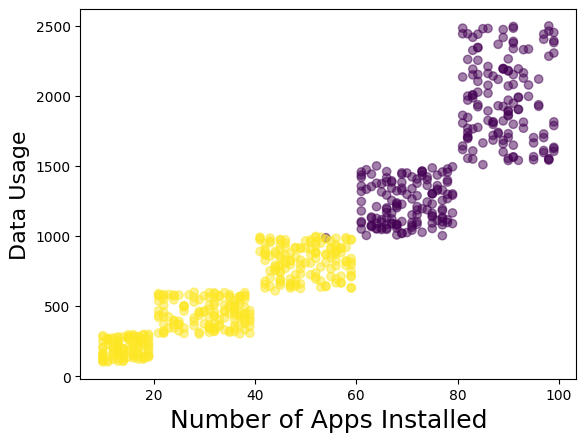

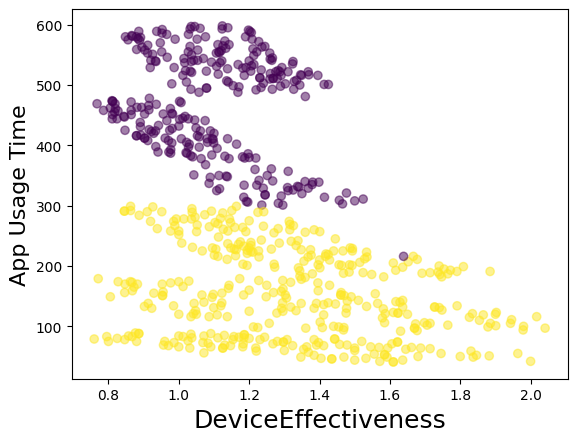

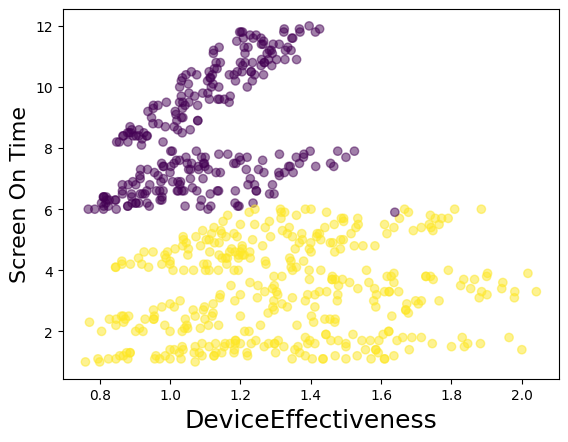

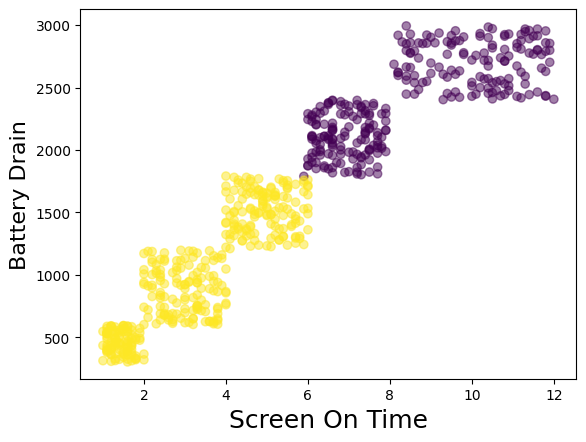

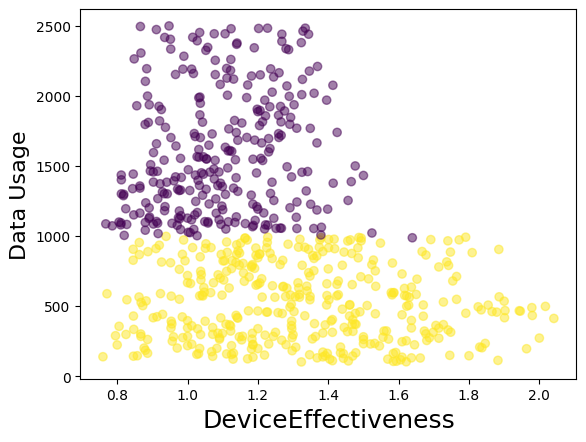

In [31]:
plt.figure()
plt.scatter(dataCopy['App Usage Time (min/day)'], dataCopy['Screen On Time (hours/day)'], c=labels.astype(float), alpha=.5)
plt.xlabel('App Usage Time', fontsize=18)
plt.ylabel('Screen On Time', fontsize=16)

plt.figure()
plt.scatter(dataCopy['App Usage Time (min/day)'], dataCopy['Number of Apps Installed'], c=labels.astype(float), alpha=.5)
plt.xlabel('App Usage Time', fontsize=18)
plt.ylabel('Number of Apps Installed', fontsize=16)

plt.figure()
plt.scatter(dataCopy['Number of Apps Installed'], dataCopy['Data Usage (MB/day)'], c=labels.astype(float), alpha=.5)
plt.xlabel('Number of Apps Installed', fontsize=18)
plt.ylabel('Data Usage', fontsize=16)

plt.figure()
plt.scatter(dataCopy['DeviceEffectiveness'], dataCopy['App Usage Time (min/day)'], c=labels.astype(float), alpha=.5)
plt.xlabel('DeviceEffectiveness', fontsize=18)
plt.ylabel('App Usage Time', fontsize=16)

plt.figure()
plt.scatter(dataCopy['DeviceEffectiveness'], dataCopy['Screen On Time (hours/day)'], c=labels.astype(float), alpha=.5)
plt.xlabel('DeviceEffectiveness', fontsize=18)
plt.ylabel('Screen On Time', fontsize=16)

plt.figure()
plt.scatter(dataCopy['Screen On Time (hours/day)'], dataCopy['Battery Drain (mAh/day)'], c=labels.astype(float), alpha=.5)
plt.xlabel('Screen On Time', fontsize=18)
plt.ylabel('Battery Drain', fontsize=16)

plt.figure()
plt.scatter(dataCopy['DeviceEffectiveness'], dataCopy['Data Usage (MB/day)'], c=labels.astype(float), alpha=.5)
plt.xlabel('DeviceEffectiveness', fontsize=18)
plt.ylabel('Data Usage', fontsize=16)

Вывод: На построенных нами графиках можно увидеть, что значения на каждом из них разделились на два кластера, при этом перемешанные значения минимальны. Благодаря графикам можем просто и точно охарактеризовать зависимости между определенными значениями из датасета. Например, прослеживается зависимость между тем, что чем меньше значение эффективности девайса, тем больше на девайсе используются приложения и память, но при этом меньше времени работает экран. Это можно объяснить тем, что простая работа экрана будет ухудшать эффективность работы, так как ничего полезного происходить с девайсом не будет. На остальных графиках можем видеть прямую зависимость одной величины от другой(например, чем дольше работает экран, тем более высокая энергопотеря девайса или что увеличение количества установленных приложений увеличивает использование памяти)